In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
import math
import random
from nltk.tokenize import TweetTokenizer,RegexpTokenizer,word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from string import punctuation
import re
import seaborn as sns
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import plot_confusion_matrix
import pickle
import emot
import contractions

In [ ]:
def init():
    train = pd.read_csv("data/train.csv",encoding="iso-8859-1",header=None)
    test = pd.read_csv("data/test.csv",encoding="iso-8859-1",header=None)
    return train,test

In [ ]:
train,test = init()

# A

In [ ]:
train.head()

In [ ]:
train4 = train[train[0]==4]
train0 = train[train[0]==0]
len(train4[5].unique())

In [ ]:
# Pass data,column of text
def getVocab(train,col):
    vocab = {}
    count=0
#     data = []
    data = train[col].unique()
    for i in range(data.shape[0]):
        x = []
        words = data[i].replace("."," ").split(" ")
#         words = data[i].split(" ")
        if " " in words:
            words.remove(" ")
        for j in words:
            if(j not in vocab):
                vocab[j]=count
                count = count+1
#             x.append(j)
#                 x.append(vocab[j])
#         data.append(x)
#     train[1]=data
    return vocab

In [ ]:
st = time()
vocab = getVocab(train,5)
print(time()-st)

In [ ]:
len(vocab)

In [ ]:
# 0 = Negative 4 = Positive 2 = Neutral

# Pass the column of full data,column's number and vocabulary
def findParamVocab(data,vocab,col):
    v = vocab.fromkeys(vocab,1)
    total = len(vocab)
    data = data[col].unique()
    for i in data:
#         total=total+len(i.split(" "))
        words = i.replace("."," ").split(" ")
#         words = i.split(" ")
        while " " in words:
            words.remove(" ")
        while "" in words:
            words.remove("")
        total = total+len(words)
        for j in words:
            v[j] = v[j]+1
    for key in v:
        v[key] = float(v[key]/total)
    return v,total
    
def learnParam(train,vocab,col):
    m=train.shape[0]
    train4 = train[train[0]==4]
    train0 = train[train[0]==0]
    phi0 = (len(train0[col].unique()))/(m)
    phi4 = (len(train4[col].unique()))/(m)
#     phi0 = (train[train[0]==0].shape[0]+1)/(m+2)
#     phi2 = (train[train[0]==2].shape[0]+1)/m
#     phi4 = (train[train[0]==4].shape[0]+1)/(m+2)
    param0,t0 = findParamVocab(train[train[0]==0],vocab,col)
#     param2,t2 = findParamVocab(train[train[0]==2],vocab,col)
    param4,t4 = findParamVocab(train[train[0]==4],vocab,col)
#     return phi0,phi2,phi4,param0,param2,param4,t0,t2,t4
    return phi0,phi4,param0,param4,t0,t4

In [ ]:
st = time()
phi0,phi4,theta0,theta4,t0,t4 = learnParam(train,vocab,5)
print(time()-st)

In [ ]:
# Pass the column of text
# def findClasses(data,phi0,phi1,phi2,theta0,theta2,theta4,t0,t2,t4):
def findClasses(data,phi0,phi4,theta0,theta4,t0,t4):
    pred = []
    pred0 = []
    pred4 = []
    for i in data:
        prob0 = 0
        prob2 = 0
        prob4 = 0
        words = i.split(" ")
        if " " in words:
            words.remove(" ")
        for j  in words:
            try:
                prob0 = prob0+(math.log(theta0[j]))
            except:
                prob0 = prob0+float(1/(t0+1))
                
#             if(j in theta2):
#             try:
#                 prob2 = prob2+(math.log(theta2[j]))
#             except:
#                 prob2 = prob2+float(1/(t2+1))
                
#             if(j in theta4):
            try:
                prob4 = prob4+(math.log(theta4[j]))
            except:
                prob4 = prob4+float(1/(t4+1))
                
        prob0 = prob0+(math.log(phi0))
#         prob2 = prob2+(math.log(phi2))
        prob4 = prob4+(math.log(phi4))
        if(prob0>prob4):
            pred.append(0)
#         elif(prob2>prob0 and prob2>prob4):
#             pred.append(2)
        else:
            pred.append(4)
        pred0.append(prob0)
        pred4.append(prob4)
    return pred,pred0,pred4

In [ ]:
st = time()
# predictionTrain = findClasses(train[5],phi0,phi2,phi4,theta0,theta2,theta4,t0,t2,t4)
predictionTrain,pred0,pred4 = findClasses(train[5],phi0,phi4,theta0,theta4,t0,t4)
print(time()-st)

In [ ]:
check = (train[0]==predictionTrain)

In [ ]:
t=0
f=0
for i in check:
    if i:
        t=t+1
    else:
        f=f+1
print(t/(t+f))

In [ ]:
st = time()
test = test[test[0]==0].append(test[test[0]==4])
predictionTest,predTest0,predTest4 = findClasses(test[5],phi0,phi4,theta0,theta4,t0,t4)
print(time()-st)

In [ ]:
check = (test[0]==predictionTest)
t=0
f=0
for i in check:
    if i:
        t=t+1
    else:
        f=f+1
print(t/(t+f))

# B

In [ ]:
def randomGuess(data):
    choices=[0,4]
    pred=[]
    for i in data:
        pred.append(random.choice(choices))
    return pred

In [ ]:
st = time()
predictionRandom = randomGuess(test[5])
print(time()-st)

In [ ]:
check = (test[0]==predictionRandom)
t=0
f=0
for i in check:
    if i:
        t=t+1
    else:
        f=f+1
print(t/(t+f))

In [ ]:
def majorityGuess(train,test):
    c0 = train[train[0]==0][5].unique().shape[0]
#     c2 = train[train[0]==2].shape[0]
    c4 = train[train[0]==4][5].unique().shape[0]
    m=0
    if(c0>c4):
        m=0
#     elif(c2>c0 and c2>c4):
#         m=2
    else:
        m=4
        
    pred=[]
    for i in test[5]:
        pred.append(m)
    return pred

In [ ]:
st = time()
predictionMajority = majorityGuess(train,test)
print(time()-st)

In [ ]:
check = (test[0]==predictionMajority)
t=0
f=0
for i in check:
    if i:
        t=t+1
    else:
        f=f+1
print(t/(t+f))

# C

In [ ]:
def confusionMatrix(test,prediction):
    mat = np.zeros((2,2))
    index=0
    for i in test[0]:
        mat[int(i/4)][int(prediction[index]/4)] = mat[int(i/4)][int(prediction[index]/4)]+1
        index=index+1
    return mat

In [ ]:
matrix = confusionMatrix(test,predictionTest)
matrix

In [ ]:
def drawMatrix(matrix):
    df_cm = pd.DataFrame(matrix.astype(int), index = [i for i in "04"],
                      columns = [i for i in "04"])
    plt.figure(figsize = (7,5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm,cmap="Blues", annot=True,fmt="d",linewidth=1,annot_kws={"size": 16})
    plt.show()
    
drawMatrix(matrix)

# D

In [ ]:
stemmer = PorterStemmer()
# stemmer = SnowballStemmer("english")
# tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
# tokenizer = RegexpTokenizer(r'[A-Za-z0-9]+')
# tokenizer = RegexpTokenizer(r'\w+')
stop = set(stopwords.words('english'))

In [ ]:
s = "@stustone Your show is whack. Way worse than whack, it's wiggety-whack.    :*(:*(:*("
t = "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D "
# t = t.replace("."," ")
s = contractions.fix(s.lower()).replace(","," ").replace(";"," ").replace("."," ").replace("!"," ").split(" ")
s = " ".join([stemmer.stem(j) for j in s if (stemmer.stem(j) not in stop and '@' not in j)])
emot.emoticons(s)['value']
# [stemmer.stem(j) for j in contractions.fix(t).split(" ") if (j not in stop and j not in punctuation and '@' not in j)] 


In [ ]:
# just pass the whole data
# 81.89 = words = contractions.fix(i).replace(","," ").replace(";"," ").replace("."," ").replace("!"," ").split(" ")
# 82.45 = words = (i.replace(","," ").replace(";"," ").replace("."," ").replace("!"," ")).split(" ")
# 83.00 = words = (i.replace(";"," ").replace("."," ").replace("!"," ")).split(" ")
# 83.28 = words = (i.replace("."," ").replace("!"," ")).split(" ")
def cleanText(data,col):
    temp = []
    for i in data[col]:
        words = contractions.fix(i.lower()).replace(","," ").replace(";"," ").replace("."," ").replace("!"," ").split(" ")
        temp.append(" ".join([stemmer.stem(j) for j in words if (stemmer.stem(j) not in stop and '@' not in j)]))
    data[6]=temp

In [ ]:
st=time()
cleanText(train,5)
print(time()-st)

In [ ]:
st = time()
vocabClean = getVocab(train,6)
print(time()-st)

In [ ]:
st = time()
Cphi0,Cphi4,Ctheta0,Ctheta4,Ct0,Ct4 = learnParam(train,vocabClean,6)
print(time()-st)

In [ ]:
st = time()
cleanText(test,5)
predictionTestClean,CpredTest0,CpredTest4 = findClasses(test[6],Cphi0,Cphi4,Ctheta0,Ctheta4,Ct0,Ct4)
print(time()-st)

In [ ]:
matrix = confusionMatrix(test,predictionTestClean)
drawMatrix(matrix)

In [ ]:
check = (test[0]==predictionTestClean)
t=0
f=0
for i in check:
    if i:
        t=t+1
    else:
        f=f+1
print(t/(t+f))

In [ ]:
st = time()
predictionTrainClean,CpredTrain0,CpredTrain4 = findClasses(train[6],Cphi0,Cphi4,Ctheta0,Ctheta4,Ct0,Ct4)
print(time()-st)

In [ ]:
matrix = confusionMatrix(train,predictionTrainClean)
drawMatrix(matrix)

In [ ]:
check = (train[0]==predictionTrainClean)
t=0
f=0
for i in check:
    if i:
        t=t+1
    else:
        f=f+1
print(t/(t+f))

# FEATURE

In [ ]:
# Pass data,column of text
def getAddedVocab(train,col):
    vocab = {}
    emoji = {}
    count=0
    emojiCount=0
#     data = []
    data = train[col].unique()
    for i in range(data.shape[0]):
        x = []
#         words = train[col][i].replace(';',' ').replace("."," ").replace(","," ").split(" ")
        words = data[i].split(" ")
        while " " in words:
            words.remove(" ")
        while "" in words:
            words.remove('')
        for j in words:
            if(j not in vocab):
                vocab[j]=count
                count = count+1
        for j in range(0,len(words)-1):
            if(words[j]+" "+words[j+1] not in vocab):
                vocab[words[j]+" "+words[j+1]]=count
                count = count+1
        
        try:
            for j in emot.emoticons(data[i])['value']:
                if(j not in emoji):
                    emoji[j]=emojiCount
                    emojiCount = emojiCount+1
        except:
            pass

#             x.append(j)
#                 x.append(vocab[j])
#         data.append(x)
#     train[1]=data
    return vocab,emoji

In [ ]:
st = time()
addedVocab,emojiVocab = getAddedVocab(train,6)
print(time()-st)
print(len(addedVocab))

In [ ]:
# 0 = Negative 4 = Positive 2 = Neutral

# Pass the column of full data,column's number and vocabulary
def findAddedParamVocab(data,vocab,col):
    v = vocab.fromkeys(vocab,1)
#     print(v)
    total = len(vocab)
    data = data[col].unique()
    for i in data:
#         total=total+len(i.split(" "))
        words = i.split(" ")
        while " " in words:
            words.remove(" ")
        while "" in words:
            words.remove("")
        total = total+2*len(words)-1
        for j in words:
            v[j] = v[j]+1
        for j in range(0,len(words)-1):
            v[words[j]+" "+words[j+1]] = v[words[j]+" "+words[j+1]]+1
    for key in v:
        v[key] = float(v[key]/total)
    v = {k: v for k, v in sorted(v.items(), key=lambda item: item[1],reverse=True)}
    return v,total
#     return v

# def findTotalValues(param):
#     sorted_x = {k: v for k, v in sorted(param.items(), key=lambda item: item[1])}
#     sorted_x = dict(sorted(param.items(), key=operator.itemgetter(1),reverse=True))
#     print(sorted_x[:50])

def findEmojiVocab(data,vocab,col):
    v = vocab.fromkeys(vocab,1)
#     print(v)
    total = len(vocab)
    data = data[col].unique()
    for i in data:
        words = i.split(" ")
        while " " in words:
            words.remove(" ")
        while "" in words:
            words.remove("")
#         total = total+2*len(words)-1

        try:
            for j in emot.emoticons(data[i])['value']:
                v[j]=v[j]+1
        except:
            pass

    for key in v:
        v[key] = float(v[key]/total)
    return v,total

    
def learnAddedParam(train,vocab,emoji,col):
    m=train.shape[0]
    train4 = train[train[0]==4]
    train0 = train[train[0]==0]
    phi0 = (len(train0[col].unique()))/(m)
#     phi2 = (train[train[0]==2].shape[0]+1)/m
    phi4 = (len(train4[col].unique()))/(m)
    param0,t0 = findAddedParamVocab(train[train[0]==0],vocab,col)
    emoji0,e0 = findEmojiVocab(train[train[0]==0],emoji,col)
#     print(param0)
#     param2,t2 = findParamVocab(train[train[0]==2],vocab,col)
    param4,t4 = findAddedParamVocab(train[train[0]==4],vocab,col)
    emoji4,e4 = findEmojiVocab(train[train[0]==4],emoji,col)
#     return phi0,phi2,phi4,param0,param
    return phi0,phi4,param0,param4,t0,t4,emoji0,e0,emoji4,e4

In [ ]:
st = time()
phiF0,phiF4,thetaF0,thetaF4,tF0,tF4,emoji0,e0,emoji4,e4 = learnAddedParam(train,addedVocab,emojiVocab,6)
print(time()-st)

In [ ]:
# Pass the column of text
# def findClasses(data,phi0,phi1,phi2,theta0,theta2,theta4,t0,t2,t4):
def findAddedClasses(data,phi0,phi4,theta0,theta4,t0,t4,emoji0,emoji4,e0,e4):
    pred = []
    pred0 = []
    pred4 = []
    l0=[]
    count=0
    for i in theta0.keys():
        l0.append(i)
        if(count>100):
            break
        count+=1
    l4=[]
    count=0
    for i in theta4.keys():
        l4.append(i)
        if(count>100):
            break
        count+=1
    
    for i in data:
        prob0 = 0
        prob4 = 0
        words = i.split(" ")
        while " " in words:
            words.remove(" ")
        while "" in words:
            words.remove("")
        count0=1
        count4=1
        for j  in words:
            if j in l0:
                count0+=1
            try:
                prob0 = prob0+(math.log(theta0[j]))
            except:
                prob0 = prob0+float(1/(t0+1))
            if j in l4:
                count4+=1
            try:
                prob4 = prob4+(math.log(theta4[j]))
            except:
                prob4 = prob4+float(1/(t4+1))
                
        for j in range(0,len(words)-1):
            try:
                prob0 = prob0+(math.log(theta0[words[j]+" "+words[j+1]]))
            except:
                prob0 = prob0+float(1/(t0+1))
            try:
                prob4 = prob4+(math.log(theta4[words[j]+" "+words[j+1]]))
            except:
                prob4 = prob4+float(1/(t4+1))
        
        flag=0
        try:
            for j in emot.emoticons(i)['value']:
                flag=1
                prob0=prob0+math.log(emoji0[j])
                prob4=prob4+math.log(emoji4[j])
        except:
            pass
    
        if(flag==0):
            prob0 = prob0+float(1/(e0+1))
            prob4 = prob4+float(1/(e4+1))
        
        
        prob0 = prob0+(math.log(phi0))+(count0/101)
#         prob2 = prob2+(math.log(phi2))
        prob4 = prob4+(math.log(phi4))+(count4/101)
        if(prob0>prob4):
            pred.append(0)
#         elif(prob2>prob0 and prob2>prob4):
#             pred.append(2)
        else:
            pred.append(4)
        pred0.append(prob0)
        pred4.append(prob4)
    return pred,pred0,pred4

In [ ]:
st = time()
# predictionTrain = findClasses(train[5],phi0,phi2,phi4,theta0,theta2,theta4,t0,t2,t4)
predictionAddedTrain,predAdded0,predAdded4 = findAddedClasses(train[6],phiF0,phiF4,thetaF0,thetaF4,tF0,tF4,emoji0,emoji4,e0,e4)
print(time()-st)

In [ ]:
check = (train[0]==predictionAddedTrain)
t=0
f=0
for i in check:
    if i:
        t=t+1
    else:
        f=f+1
print(t/(t+f))

In [ ]:
st = time()
test = test[test[0]==0].append(test[test[0]==4])
predictionAddedTest,predAddedTest0,predAddedTest4 = findAddedClasses(test[6],phiF0,phiF4,thetaF0,thetaF4,tF0,tF4,emoji0,emoji4,e0,e4)
print(time()-st)

In [ ]:
check = (test[0]==predictionAddedTest)
t=0
f=0
for i in check:
    if i:
        t=t+1
    else:
        f=f+1
print(t/(t+f))

In [ ]:
matrix = confusionMatrix(test,predictionAddedTest)
drawMatrix(matrix)

# TF-IDF

In [ ]:
tfidf = TfidfVectorizer(min_df=0.0007)
clf = GaussianNB()
multi = MultinomialNB()

In [ ]:
train

In [ ]:
st=time()
X = tfidf.fit_transform(train[6])
print(time()-st)

In [ ]:
X.shape

In [ ]:
def tfidfVectorizer(clf,X,data):
    for i in tqdm(range(0,data.shape[0]//1000)):
        clf.partial_fit(X[1000*i:1000*(i+1)].todense(),data[0][1000*i:1000*(i+1)],classes=np.array([0,4]))
    return clf

def tfidfMultiVectorizer(multi,X,data):
    for i in tqdm(range(0,data.shape[0]//1000)):
        multi.partial_fit(X[1000*i:1000*(i+1)].todense(),data[0][1000*i:1000*(i+1)],classes=np.array([0,4]))
    return multi

In [ ]:
clf = tfidfVectorizer(clf,X,train) 

In [ ]:
# multi = tfidfMultiVectorizer(multi,train)
# filename = 'tfidfClf.sav'
# pickle.dump(clf, open(filename, 'wb'))
loaded_model = pickle.load(open("tfidfClf.sav", 'rb'))

In [ ]:
demo = MultinomialNB()
demo.fit(X,train[0])

In [ ]:
st=time()
Y = tfidf.transform(test[6])
testDense = Y.todense()
print(time()-st)

In [ ]:
type(testDense[0,0])

In [ ]:
testDense.shape

In [ ]:
predictionTestTfidf = clf.predict(testDense)

In [ ]:
check = (test[0]==predictionTestTfidf)
t=0
f=0
for i in check:
    if i:
        t=t+1
    else:
        f=f+1
print(t/(t+f))

In [ ]:
predMulti = demo.predict(Y)
check = (test[0]==predMulti)
t=0
f=0
for i in check:
    if i:
        t=t+1
    else:
        f=f+1
print(t/(t+f))

In [ ]:
train

In [ ]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(train[5])

In [ ]:
Y = train[0]
percentile = SelectPercentile(chi2, percentile=10)
selectedData = percentile.fit_transform(X,Y)

In [ ]:
clf2 = GaussianNB()
per10 = tfidfVectorizer(clf2,selectedData,train)

In [ ]:
st=time()
Y = tfidf.transform(test[6])
testDense = Y.todense()
testDense10per = percentile.transform(testDense)
print(time()-st)

In [ ]:
prediction10per = clf2.predict(testDense10per)

In [ ]:
check = (test[0]==prediction10per)
t=0
f=0
for i in check:
    if i:
        t=t+1
    else:
        f=f+1
print(t/(t+f))

# G

In [ ]:
def rocCurve(data,prob0,prob4):
    y = label_binarize(data[0],classes=[0,4])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr[0], tpr[0], _ = roc_curve(y,prob0)
    roc_auc[0] = auc(fpr[0], tpr[0])
    fpr[1], tpr[1], _ = roc_curve(y,prob4)
    roc_auc[1] = auc(fpr[1], tpr[1])

    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label='ROC curve for Class 0(area = %0.2f)' % roc_auc[0])
    plt.plot(fpr[1], tpr[1], color='cyan',lw=lw, label='ROC curve for Class 1(area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# probGaussian = loaded_model.predict_log_proba(testDense)
# probMulti = demo.predict_log_proba(Y)
# rocCurve(test,probGaussian[:,0],probGaussian[:,1])
rocCurve(test,CpredTest0,CpredTest4)

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
import math
import random
from nltk.tokenize import TweetTokenizer,RegexpTokenizer,word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from string import punctuation
import re
import seaborn as sns
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import plot_confusion_matrix
import pickle
import emot
import contractions

def init():
    train = pd.read_csv("data/train.csv",encoding="iso-8859-1",header=None)
    test = pd.read_csv("data/test.csv",encoding="iso-8859-1",header=None)
    return train,test

# Pass data,column of text
def getVocab(train,col):
    vocab = {}
    count=0
    data = train[col].unique()
    for i in range(data.shape[0]):
        x = []
        words = data[i].replace("."," ").split(" ")
        if " " in words:
            words.remove(" ")
        for j in words:
            if(j not in vocab):
                vocab[j]=count
                count = count+1
    return vocab

# 0 = Negative 4 = Positive 2 = Neutral

# Pass the column of full data,column's number and vocabulary
def findParamVocab(data,vocab,col):
    v = vocab.fromkeys(vocab,1)
    total = len(vocab)
    data = data[col].unique()
    for i in data:
        words = i.replace("."," ").split(" ")
        while " " in words:
            words.remove(" ")
        while "" in words:
            words.remove("")
        total = total+len(words)
        for j in words:
            v[j] = v[j]+1
    for key in v:
        v[key] = float(v[key]/total)
    return v,total
    
def learnParam(train,vocab,col):
    m=train.shape[0]
    train4 = train[train[0]==4]
    train0 = train[train[0]==0]
    phi0 = (len(train0[col].unique()))/(m)
    phi4 = (len(train4[col].unique()))/(m)
    param0,t0 = findParamVocab(train[train[0]==0],vocab,col)
    param4,t4 = findParamVocab(train[train[0]==4],vocab,col)
    return phi0,phi4,param0,param4,t0,t4

# Pass the column of text
def findClasses(data,phi0,phi4,theta0,theta4,t0,t4):
    pred = []
    pred0 = []
    pred4 = []
    for i in data:
        prob0 = 0
        prob2 = 0
        prob4 = 0
        words = i.split(" ")
        if " " in words:
            words.remove(" ")
        for j  in words:
            try:
                prob0 = prob0+(math.log(theta0[j]))
            except:
                prob0 = prob0+float(1/(t0+1))
            try:
                prob4 = prob4+(math.log(theta4[j]))
            except:
                prob4 = prob4+float(1/(t4+1))
                
        prob0 = prob0+(math.log(phi0))
        prob4 = prob4+(math.log(phi4))
        if(prob0>prob4):
            pred.append(0)
        else:
            pred.append(4)
        pred0.append(prob0)
        pred4.append(prob4)
    return pred,pred0,pred4

def checkAccuracy(Y,pred):
    check = (Y==pred)
    t=0
    f=0
    for i in check:
        if i:
            t=t+1
        else:
            f=f+1
    print(t/(t+f))

def randomGuess(data):
    choices=[0,4]
    pred=[]
    for i in data:
        pred.append(random.choice(choices))
    return pred

def majorityGuess(train,test):
    c0 = train[train[0]==0][5].unique().shape[0]
    c4 = train[train[0]==4][5].unique().shape[0]
    m=0
    if(c0>c4):
        m=0
    else:
        m=4
    pred=[]
    for i in test[5]:
        pred.append(m)
    return pred

def confusionMatrix(test,prediction):
    mat = np.zeros((2,2))
    index=0
    for i in test[0]:
        mat[int(i/4)][int(prediction[index]/4)] = mat[int(i/4)][int(prediction[index]/4)]+1
        index=index+1
    return mat

def drawMatrix(matrix):
    df_cm = pd.DataFrame(matrix.astype(int), index = [i for i in "04"],columns = [i for i in "04"])
    plt.figure(figsize = (7,5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm,cmap="Blues", annot=True,fmt="d",linewidth=1,annot_kws={"size": 16})
    plt.show()

def cleanText(data,col):
    temp = []
    for i in data[col]:
        words = contractions.fix(i.lower()).replace(","," ").replace(";"," ").replace("."," ").replace("!"," ").split(" ")
        temp.append(" ".join([stemmer.stem(j) for j in words if (stemmer.stem(j) not in stop and '@' not in j)]))
    data[6]=temp

# Pass data,column of text
def getAddedVocab(train,col):
    vocab = {}
    emoji = {}
    count=0
    emojiCount=0
    data = train[col].unique()
    for i in range(data.shape[0]):
        x = []
        words = data[i].split(" ")
        while " " in words:
            words.remove(" ")
        while "" in words:
            words.remove('')
        for j in words:
            if(j not in vocab):
                vocab[j]=count
                count = count+1
        for j in range(0,len(words)-1):
            if(words[j]+" "+words[j+1] not in vocab):
                vocab[words[j]+" "+words[j+1]]=count
                count = count+1
        try:
            for j in emot.emoticons(data[i])['value']:
                if(j not in emoji):
                    emoji[j]=emojiCount
                    emojiCount = emojiCount+1
        except:
            pass
    return vocab,emoji

# 0 = Negative 4 = Positive 2 = Neutral
# Pass the column of full data,column's number and vocabulary
def findAddedParamVocab(data,vocab,col):
    v = vocab.fromkeys(vocab,1)
    total = len(vocab)
    data = data[col].unique()
    for i in data:
        words = i.split(" ")
        while " " in words:
            words.remove(" ")
        while "" in words:
            words.remove("")
        total = total+2*len(words)-1
        for j in words:
            v[j] = v[j]+1
        for j in range(0,len(words)-1):
            v[words[j]+" "+words[j+1]] = v[words[j]+" "+words[j+1]]+1
    for key in v:
        v[key] = float(v[key]/total)
    v = {k: v for k, v in sorted(v.items(), key=lambda item: item[1],reverse=True)}
    return v,total

def findEmojiVocab(data,vocab,col):
    v = vocab.fromkeys(vocab,1)
    total = len(vocab)
    data = data[col].unique()
    for i in data:
        words = i.split(" ")
        while " " in words:
            words.remove(" ")
        while "" in words:
            words.remove("")
        try:
            for j in emot.emoticons(data[i])['value']:
                v[j]=v[j]+1
        except:
            pass
    for key in v:
        v[key] = float(v[key]/total)
    return v,total

def learnAddedParam(train,vocab,emoji,col):
    m=train.shape[0]
    train4 = train[train[0]==4]
    train0 = train[train[0]==0]
    phi0 = (len(train0[col].unique()))/(m)
    phi4 = (len(train4[col].unique()))/(m)
    param0,t0 = findAddedParamVocab(train[train[0]==0],vocab,col)
    emoji0,e0 = findEmojiVocab(train[train[0]==0],emoji,col)
    param4,t4 = findAddedParamVocab(train[train[0]==4],vocab,col)
    emoji4,e4 = findEmojiVocab(train[train[0]==4],emoji,col)
    return phi0,phi4,param0,param4,t0,t4,emoji0,e0,emoji4,e4

# Pass the column of text
def findAddedClasses(data,phi0,phi4,theta0,theta4,t0,t4,emoji0,emoji4,e0,e4):
    pred = []
    pred0 = []
    pred4 = []
    l0=[]
    count=0
    for i in theta0.keys():
        l0.append(i)
        if(count>100):
            break
        count+=1
    l4=[]
    count=0
    for i in theta4.keys():
        l4.append(i)
        if(count>100):
            break
        count+=1
    for i in data:
        prob0 = 0
        prob4 = 0
        words = i.split(" ")
        while " " in words:
            words.remove(" ")
        while "" in words:
            words.remove("")
        count0=1
        count4=1
        for j  in words:
            if j in l0:
                count0+=1
            try:
                prob0 = prob0+(math.log(theta0[j]))
            except:
                prob0 = prob0+float(1/(t0+1))
            if j in l4:
                count4+=1
            try:
                prob4 = prob4+(math.log(theta4[j]))
            except:
                prob4 = prob4+float(1/(t4+1))
        for j in range(0,len(words)-1):
            try:
                prob0 = prob0+(math.log(theta0[words[j]+" "+words[j+1]]))
            except:
                prob0 = prob0+float(1/(t0+1))
            try:
                prob4 = prob4+(math.log(theta4[words[j]+" "+words[j+1]]))
            except:
                prob4 = prob4+float(1/(t4+1))
        flag=0
        try:
            for j in emot.emoticons(i)['value']:
                flag=1
                prob0=prob0+math.log(emoji0[j])
                prob4=prob4+math.log(emoji4[j])
        except:
            pass
        if(flag==0):
            prob0 = prob0+float(1/(e0+1))
            prob4 = prob4+float(1/(e4+1))
        prob0 = prob0+(math.log(phi0))+(count0/101)
        prob4 = prob4+(math.log(phi4))+(count4/101)
        if(prob0>prob4):
            pred.append(0)
        else:
            pred.append(4)
        pred0.append(prob0)
        pred4.append(prob4)
    return pred,pred0,pred4

def tfidfVectorizer(clf,X,data):
    for i in tqdm(range(0,data.shape[0]//1000)):
        clf.partial_fit(X[1000*i:1000*(i+1)].todense(),data[0][1000*i:1000*(i+1)],classes=np.array([0,4]))
    return clf

def rocCurve(data,prob0,prob4):
    y = label_binarize(data[0],classes=[0,4])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr[0], tpr[0], _ = roc_curve(y,prob0)
    roc_auc[0] = auc(fpr[0], tpr[0])
    fpr[1], tpr[1], _ = roc_curve(y,prob4)
    roc_auc[1] = auc(fpr[1], tpr[1])
    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label='ROC curve for Class 0(area = %0.2f)' % roc_auc[0])
    plt.plot(fpr[1], tpr[1], color='cyan',lw=lw, label='ROC curve for Class 1(area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

Prediction Train 33.797382831573486
0.845434375
Prediction Test
0.8050139275766016
Random Guess
0.4986072423398329
Majority Guess
0.5069637883008357


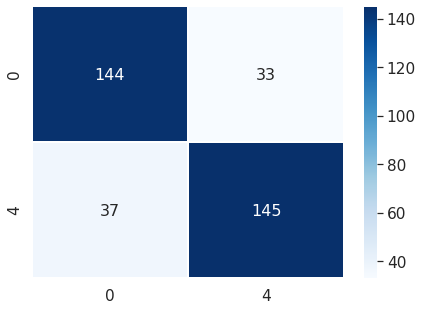

Data Cleaned 443.89093255996704


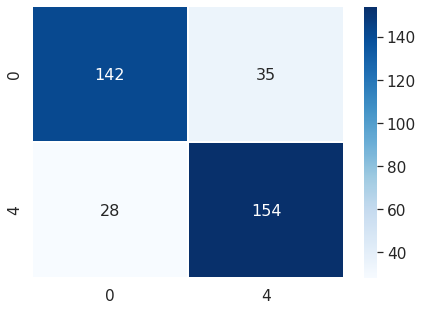

Prediction on Clean Test
0.8245125348189415
Prediction on Clean Train
0.8008575
Added Vocabulary 75.79431867599487
Prediction on train after adding features
0.90364125
Prediction on test after adding features
0.841225626740947


In [21]:
train,test = init()

# PART A

t = time()
vocab = getVocab(train,5)
# print(len(vocab))
phi0,phi4,theta0,theta4,t0,t4 = learnParam(train,vocab,5)
predictionTrain,pred0,pred4 = findClasses(train[5],phi0,phi4,theta0,theta4,t0,t4)
print("Prediction Train",time()-t)
checkAccuracy(train[0],predictionTrain)

test = test[test[0]==0].append(test[test[0]==4])
predictionTest,predTest0,predTest4 = findClasses(test[5],phi0,phi4,theta0,theta4,t0,t4)
print("Prediction Test")
checkAccuracy(test[0],predictionTest)

# PART B

predictionRandom = randomGuess(test[5])
print("Random Guess")
checkAccuracy(test[0],predictionRandom)

predictionMajority = majorityGuess(train,test)
print("Majority Guess")
checkAccuracy(test[0],predictionMajority)

# PART C

matrix = confusionMatrix(test,predictionTest)
drawMatrix(matrix)

# PART D

stop = set(stopwords.words("english"))
stemmer = PorterStemmer()

st=time()
cleanText(train,5)
print("Data Cleaned",time()-st)

vocabClean = getVocab(train,6)
Cphi0,Cphi4,Ctheta0,Ctheta4,Ct0,Ct4 = learnParam(train,vocabClean,6)
cleanText(test,5)
predictionTestClean,CpredTest0,CpredTest4 = findClasses(test[6],Cphi0,Cphi4,Ctheta0,Ctheta4,Ct0,Ct4)

matrix = confusionMatrix(test,predictionTestClean)
drawMatrix(matrix)
print("Prediction on Clean Test")
checkAccuracy(test[0],predictionTestClean)

predictionTrainClean,CpredTrain0,CpredTrain4 = findClasses(train[6],Cphi0,Cphi4,Ctheta0,Ctheta4,Ct0,Ct4)
print("Prediction on Clean Train")
checkAccuracy(train[0],predictionTrainClean)

# PART E

st = time()
addedVocab,emojiVocab = getAddedVocab(train,6)
print("Added Vocabulary",time()-st)

phiF0,phiF4,thetaF0,thetaF4,tF0,tF4,emoji0,e0,emoji4,e4 = learnAddedParam(train,addedVocab,emojiVocab,6)
predictionAddedTrain,predAdded0,predAdded4 = findAddedClasses(train[6],phiF0,phiF4,thetaF0,thetaF4,tF0,tF4,emoji0,emoji4,e0,e4)

print("Prediction on train after adding features")
checkAccuracy(train[0],predictionAddedTrain)

test = test[test[0]==0].append(test[test[0]==4])
predictionAddedTest,predAddedTest0,predAddedTest4 = findAddedClasses(test[6],phiF0,phiF4,thetaF0,thetaF4,tF0,tF4,emoji0,emoji4,e0,e4)
print("Prediction on test after adding features")
checkAccuracy(test[0],predictionAddedTest)

In [61]:
test[test[0]==4][5].to_csv("temp.csv")

In [47]:
tfidf = TfidfVectorizer(min_df=0.0007)
clf = GaussianNB()
X = tfidf.fit_transform(train[6])
clf = tfidfVectorizer(clf,X,train)
Y = tfidf.transform(test[6])
testDense = Y.todense()
predictionTestTfidf = clf.predict(testDense)
logProbaTest = clf.predict_log_proba(testDense)

tfidf = TfidfVectorizer(min_df=0.0007)
X = tfidf.fit_transform(train[6])
multiClf = MultinomialNB()
multiClf.fit(X,train[0])
Y = tfidf.transform(test[6])
testDense = Y.todense()
predictionTestmulti = multiClf.predict(testDense)
logProbaTestMulti = clf.predict_log_proba(testDense)

print("Accuracy over GaussianNB")
checkAccuracy(test[0],predictionTestTfidf)
print("Accuracy over MultinomialNB")
checkAccuracy(test[0],predictionTestmulti)

tfidf = TfidfVectorizer(min_df=200)
X = tfidf.fit_transform(train[6])
Y = train[0]
percentile = SelectPercentile(chi2, percentile=10)
selectedData = percentile.fit_transform(X,Y)

clf2 = GaussianNB()
per10 = tfidfVectorizer(clf2,selectedData,train)

testData = tfidf.transform(test[6])
testDense10per = percentile.transform(testData)
prediction10per = clf2.predict(testDense10per.todense())
logProbaTestPer = clf2.predict_log_proba(testDense10per.todense())
print("Percentile Selected: 10per")
checkAccuracy(test[0],prediction10per)


 79%|███████▉  | 1264/1600 [00:15<00:04, 80.42it/s]


100%|██████████| 1600/1600 [00:20<00:00, 79.66it/s]


Accuracy over GaussianNB
0.8105849582172702
Accuracy over MultinomialNB
0.8050139275766016



100%|██████████| 1600/1600 [00:06<00:00, 256.00it/s]


Percentile Selected: 10per
0.7688022284122563


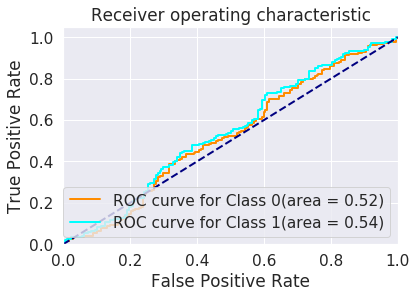

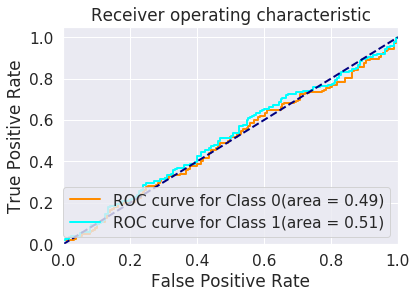

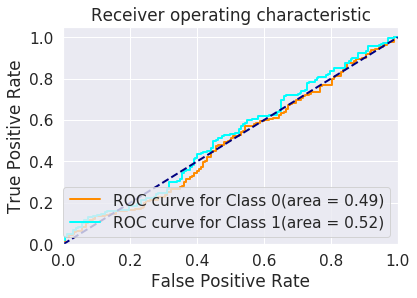

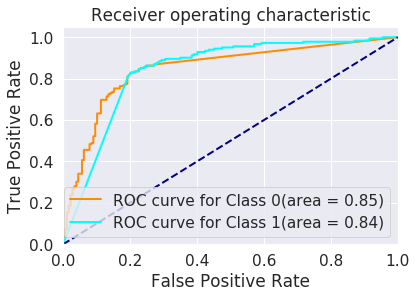

In [71]:
rocCurve(test,predTest0,predTest4)
rocCurve(test,CpredTest0,CpredTest4)
rocCurve(test,predAddedTest0,predAddedTest4)
rocCurve(test,-logProbaTestMulti[:,0],logProbaTestMulti[:,1])